# Hands-on Day 2

- course [slides](https://github.com/leggerf/MLCourse-INFN-2021/blob/master/Slides/Day2/Big%20data%20science%20-%20Day%202%20-%20INFN%202021.pdf)


## You'll learn

### ML methods
- Gradient Boosting Trees with pyspark.ml

### ML techniques
- hyperparameter optimisation
- ROC curves

In [1]:
#initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# our custom functions
from custom_functions import *

#### Remember to start spark by clicking on the square icon all the way to the right

Setup and restart the Spark context with our configuration

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

# get token to authenticate to minio storage
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

# build Spark configuration options    
conf = setupSpark(token)

# to update Spark config, we need first to stop the spark context
SparkContext.stop(sc)

# Then create first spark context, and then session
sc = SparkContext(conf = conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# check if Spark is there
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

# Data preprocessing

In [7]:
#inputFile = "s3a://legger/MLCourseInput/Higgs100k.parquet" # use this for development
inputFile = "s3a://legger/MLCourseInput/Higgs1M.parquet" # use this for final results

%time df = spark.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 12.4 ms, sys: 3.18 ms, total: 15.6 ms
Wall time: 693 ms
There are 999999 events


#  Exercise 1

- split the dataframe *df* into two dataframes, called *train* and *test* containing respectively 80% and 20% of the events (randomly distributed between the two samples) 

In [8]:
#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 799856
Events for validation 200143


#### Create the input feature vector - remember, this was part of yesterday hands-on (bonus)

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe *train* a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer
- do the same for dataframe *test*

In [9]:
# create the input feature vector 
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

# ML models: GBT

In [10]:
# ML model: GBT (Gradient Boosting Trees)
# Documentation at https://spark.apache.org/docs/2.2.0/ml-classification-regression.html
from pyspark.ml.classification import GBTClassifier

# slow, 25 minutes training time    "spark.executor.memory", "1g" "spark.executor.instances", "4")
#gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10) #slow

# fast, about 1m to train
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10, maxDepth=3) 

In [11]:
%%time
gbt_model = gbt.fit(train)

CPU times: user 600 ms, sys: 130 ms, total: 730 ms
Wall time: 1min 44s


In [12]:
# compute AUC on the test set
result = gbt_model.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.7425495625328116


In [13]:
#print metrics
printMetrics(evaluator, result)

AUC: 0.743
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|75764|
|  0.0|       1.0|35218|
|  1.0|       0.0|29824|
|  0.0|       0.0|59337|
+-----+----------+-----+

n precision: 0.683
n recall: 0.718
n accuracy: 0.675
n F1 score: 0.700


In [14]:
gbt_model.extractParamMap()

{Param(parent='GBTClassifier_60a947ee5e8f', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_60a947ee5e8f', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_60a947ee5e8f', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

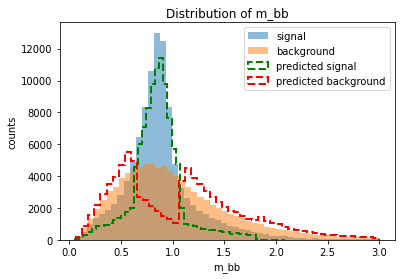

In [15]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

# Hyperparameter scan

- documentation: https://spark.apache.org/docs/latest/ml-tuning.html

In [16]:
#reduce number of events for training if needed
subSample = train.sample(fraction=1.0/10, withReplacement=False).cache()
print('We will use ' +str(subSample.count()) + ' events for the grid search')

We will use 79910 events for the grid search


In [17]:
#Do hyperparameter tuning 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10, maxDepth=3)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

#choose hyperparameter space
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [1,5])\
  .addGrid(gbt.maxIter, [10,20])\
  .build()

# Exercise 3

- try implementing the cross validation method, and describe what changes (results, training time, performances, ...): do you get the same hyper-parameters?

In [19]:
# n k cross validation (takes 6-8 minutes)
cv = CrossValidator(estimator=gbt, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=10, parallelism=3)  #increase numFolds carefully, tipycally this would be 3 or 10

In [20]:
#or (takes 1-2 minutes)
tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)# 80% of the data will be used for training, 20% for validation

**TIP:** after starting the following cell, close the Spark monitoring window or it will slow down your notebook display considerably.

In [21]:
#take care, might take long time, 
#%time bestModel = cv.fit(subSample)
%time bestModel = tvs.fit(subSample)

CPU times: user 5.19 s, sys: 1.08 s, total: 6.27 s
Wall time: 2min 5s


In [22]:
#It is possile to see the score obtained (in this case the AUC) for each set of parameters
#zip(bestModel.avgMetrics, paramGrid)

print('maxDepth = '+str(bestModel.bestModel._java_obj.getMaxDepth()))
print('maxIter = '+str(bestModel.bestModel._java_obj.getMaxIter()))

maxDepth = 5
maxIter = 20


In [23]:
# compute accuracy on the test set
result = bestModel.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.7765637804555723


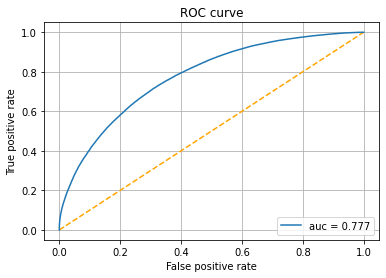

In [24]:
#make ROC curve with best model
drawROC(result)

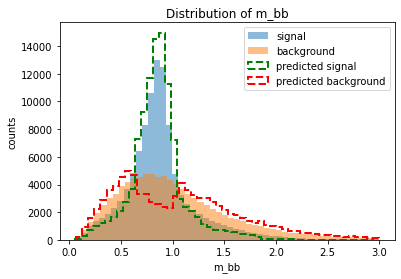

In [25]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

In [ ]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()